# beetle: PSAR smoothing の評価

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime
import re
from collections import deque
from sys import stdout

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import dates as mdates
from scipy.differentiate import derivative
from scipy.interpolate import make_smoothing_spline

from beetle.beetle_psar import RealtimePSAR
from funcs.tse import get_ticker_name_list

pattern = re.compile(r".+([0-9]{4})([0-9]{2})([0-9]{2})\.xlsx")

In [3]:
name_excel = "../excel/tick_20250801.xlsx"
ticker = "7011"
# ticker = "7203"
# ticker = "8306"

m = pattern.match(name_excel)
if m:
    year = m.group(1)
    month = m.group(2)
    day = m.group(3)
else:
    year = "1970"
    month = "01"
    day = "01"
date_str = f"{year}-{month}-{day}"
df = pd.read_excel(name_excel, sheet_name=ticker)
df.index = pd.to_datetime([datetime.datetime.fromtimestamp(t) for t in df["Time"]])
df

,Time,Price
2025-08-01 09:00:02.167416,1.754006e+09,3625
2025-08-01 09:00:04.117909,1.754006e+09,3627
2025-08-01 09:00:04.251168,1.754006e+09,3627
2025-08-01 09:00:05.182483,1.754006e+09,3627
2025-08-01 09:00:06.176907,1.754006e+09,3620
...,...,...
2025-08-01 15:24:45.823777,1.754029e+09,3606
2025-08-01 15:24:46.812595,1.754029e+09,3606
2025-08-01 15:24:47.819796,1.754029e+09,3606
2025-08-01 15:24:48.826857,1.754029e+09,3606


In [4]:
ts = df.index[0].timestamp()
print(ts)
pd.Timestamp(ts, unit="s")

1754038802.167416


Timestamp('2025-08-01 09:00:02.167416096')

## スムージング処理

In [5]:
total = len(df)
df["x"] = [r for r in range(len(df))]

n = 600
m = 60
xs_deque = deque(maxlen=n)
prices_deque = deque(maxlen=n)
lam = 10**7

for i, t in enumerate(df.index):
    x = df.at[t, "x"]
    price = df.at[t, "Price"]

    xs_deque.append(x)
    prices_deque.append(price)

    if len(xs_deque) > m:
        spl = make_smoothing_spline(xs_deque, prices_deque, lam=lam)
        df.at[t, "y"] = spl(x)
        deriv = derivative(spl, x)
        df.at[t, "dy"] = abs(deriv.df)
        stdout.write(f"\rCompleted {i + 1} / {total}")
        stdout.flush()
df

Completed 19378 / 19378

,Time,Price,x,y,dy
2025-08-01 09:00:02.167416,1.754006e+09,3625,0,NaN,NaN
2025-08-01 09:00:04.117909,1.754006e+09,3627,1,NaN,NaN
2025-08-01 09:00:04.251168,1.754006e+09,3627,2,NaN,NaN
2025-08-01 09:00:05.182483,1.754006e+09,3627,3,NaN,NaN
2025-08-01 09:00:06.176907,1.754006e+09,3620,4,NaN,NaN
...,...,...,...,...,...
2025-08-01 15:24:45.823777,1.754029e+09,3606,19373,3604.872878,0.018644
2025-08-01 15:24:46.812595,1.754029e+09,3606,19374,3604.882669,0.018287
2025-08-01 15:24:47.819796,1.754029e+09,3606,19375,3604.892563,0.017933
2025-08-01 15:24:48.826857,1.754029e+09,3606,19376,3604.902557,0.017582


In [6]:
df["dy"].describe()

count    1.931800e+04
mean     1.847549e-02
std      2.066943e-02
min      2.607703e-07
25%      5.846075e-03
50%      1.287394e-02
75%      2.387596e-02
max      3.487968e-01
Name: dy, dtype: float64

## チャート

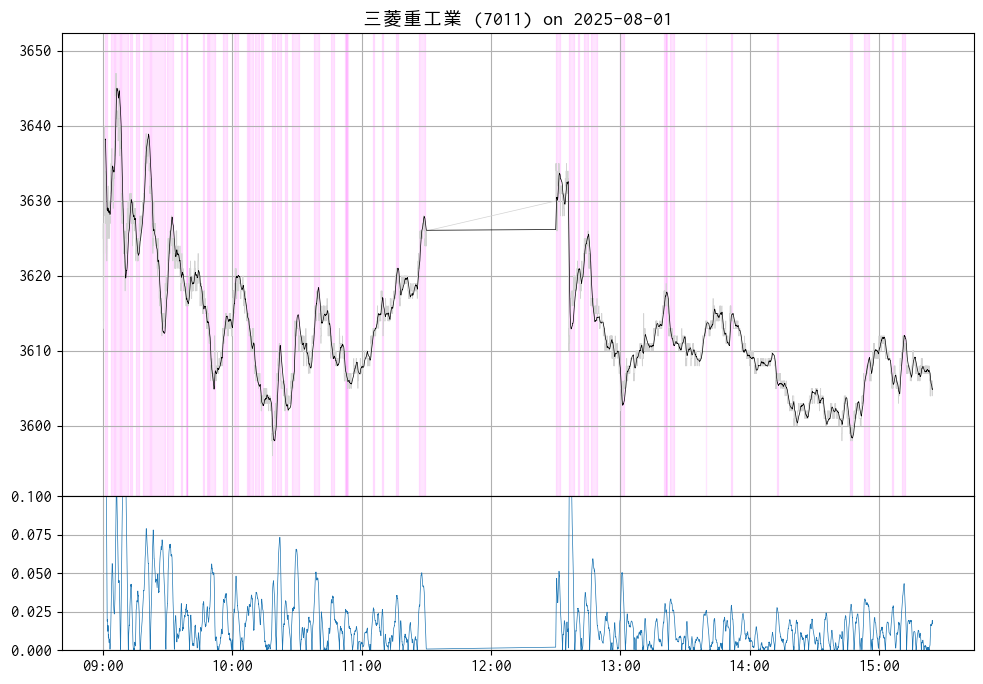

In [8]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 12
# plt.style.use("dark_background")

ax = dict()
n = 2

if n > 1:
    fig = plt.figure(figsize=(10, 7))
    gs = fig.add_gridspec(
        n,
        1,
        wspace=0.0,
        hspace=0.0,
        height_ratios=[3 if i == 0 else 1 for i in range(n)],
    )
    for i, axis in enumerate(gs.subplots(sharex="col")):
        ax[i] = axis
        ax[i].grid()
else:
    fig, ax[0] = plt.subplots(figsize=(10, 5))
    ax[0].grid()

ax[0].plot(df["Price"], color="lightgray", linewidth=0.5)
ax[0].plot(df["y"], color="black", linewidth=0.5)

ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
dict_name = get_ticker_name_list([ticker])
ax[0].set_title(f"{dict_name[ticker]} ({ticker}) on {date_str}")

ax[1].plot(df["dy"], linewidth=0.5)
# ax[1].set_yscale("log")
ax[1].set_ylim(0, 0.1)

threshold = 0.025
ax[0].fill_between(
    df.index,
    0,
    1,
    where=df["dy"] > threshold,
    color="magenta",
    alpha=0.1,
    transform=ax[0].get_xaxis_transform(),
)
plt.tight_layout()
# plt.savefig(f"screenshots/psar_smoothing_{date_str}_{ticker}.png")
plt.show()